Some implementations of MLP on MNIST using Adam and NosAdam optimizers

15.05.2022

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #magic line to deal with my versions of libraries

In [2]:
#loading data (there should be another way to do it using transforms and DataLoader)

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [3]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000
data_folder = 'mnist_data'

train_images_path = os.path.join(data_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

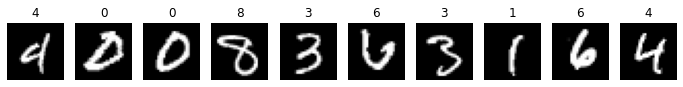

In [4]:
#some plots

prng = np.random.RandomState(seed=42)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

In [5]:
#from numpy array to torch tensor

features_train=torch.from_numpy(train_images)
features_test=torch.from_numpy(test_images)
print('Training features:', features_train.shape, '\n'
'Testing features:', features_test.shape)

labels_train=torch.from_numpy(train_labels)
labels_test=torch.from_numpy(test_labels)
print('Training labels:', labels_train.shape, '\n'
'Testing labels:', labels_test.shape)

Training features: torch.Size([60000, 28, 28]) 
Testing features: torch.Size([10000, 28, 28])
Training labels: torch.Size([60000]) 
Testing labels: torch.Size([10000])


In [19]:
#normalization

mean, std = features_train.float().mean(), features_train.float().std()

features_train = features_train.float().sub_(mean).div_(std)
features_test = features_test.float().sub_(mean).div_(std)

In [21]:
# defining MLP class

class MLP(nn.Module):
    
    def __init__(self, hidden_size_1=512, hidden_size_2=100, hidden_size_3=10):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size_1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size_1, hidden_size_2))
            # nn.ReLU(inplace=True),
            # nn.Linear(hidden_size_2, hidden_size_3)) #maybe try more layers
    
    # forward pass
    def forward(self, x):
        return self.layers(x)

mlp = MLP()
print(mlp)

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=100, bias=True)
  )
)


In [7]:
# defining accuracy function

def accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [22]:
# MLP implementation function

def mlp_nn(x_train, y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch):
    loss_all_train, loss_all_test = [], []
    epochs_all = torch.arange(1, num_epoch+num_epoch/10, num_epoch/10)
    epochs_all[-1] = num_epoch - 1
            
    for epoch in range(num_epoch):
        for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        if epoch % 20 == 0:
            loss_train = loss_train.detach().numpy()
            loss_all_train.append(loss_train)

            y_test_obt = model(x_test)
            loss_test = criterion(y_test_obt, y_test)
            loss_test = loss_test.detach().numpy()
            loss_all_test.append(loss_test)
            acc = accuracy(y_test_obt, y_test)
            
            print ('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f, Accuracy: %.4f' 
            %(epoch+1, num_epoch, loss_train, loss_test, acc))

        if epoch == num_epoch - 1:
            loss_train = loss_train.detach().numpy()
            loss_all_train.append(loss_train)

            y_test_obt = model(x_test)
            loss_test = criterion(y_test_obt, y_test)
            loss_test = loss_test.detach().numpy()
            loss_all_test.append(loss_test)
            acc = accuracy(y_test_obt, y_test)
            
            print('Final, Train Loss: %.4f, Test Loss: %.4f, Accuracy: %.4f' %(loss_train, loss_test, acc))

            # plotting train and test loss

            fig, axs = plt.subplots(1, 2, figsize=(10, 8))
            axs[0].plot(epochs_all, loss_all_train, linewidth=2.5, color='blue')
            axs[0].set_ylabel('Train Loss', fontsize=12)
            axs[0].set_xlabel('Epoch', fontsize=12)

            axs[1].plot(epochs_all, loss_all_test, linewidth=2.5, color='orange')
            axs[1].set_ylabel('Test Loss', fontsize=12)
            axs[1].set_xlabel('Epoch', fontsize=12)
            fig.suptitle('MLP Convergence', fontsize=15)
            plt.show()

    return loss_all_train, loss_all_test

In the following cells, I did several runs of MLP using Adam and varying batch size and learning rate

Epoch [1/200], Train Loss: 0.2637, Test Loss: 0.1551, Accuracy: 0.9496
Epoch [21/200], Train Loss: 0.0021, Test Loss: 0.1109, Accuracy: 0.9800
Epoch [41/200], Train Loss: 0.0814, Test Loss: 0.1716, Accuracy: 0.9788
Epoch [61/200], Train Loss: 0.0021, Test Loss: 0.1919, Accuracy: 0.9804
Epoch [81/200], Train Loss: 0.0000, Test Loss: 0.2133, Accuracy: 0.9808
Epoch [101/200], Train Loss: 0.0000, Test Loss: 0.2356, Accuracy: 0.9827
Epoch [121/200], Train Loss: 0.0028, Test Loss: 0.2817, Accuracy: 0.9817
Epoch [141/200], Train Loss: 0.0000, Test Loss: 0.2319, Accuracy: 0.9843
Epoch [161/200], Train Loss: 0.0000, Test Loss: 0.2319, Accuracy: 0.9848
Epoch [181/200], Train Loss: 0.0000, Test Loss: 0.2340, Accuracy: 0.9850
Final, Train Loss: 0.0000, Test Loss: 0.2256, Accuracy: 0.9857


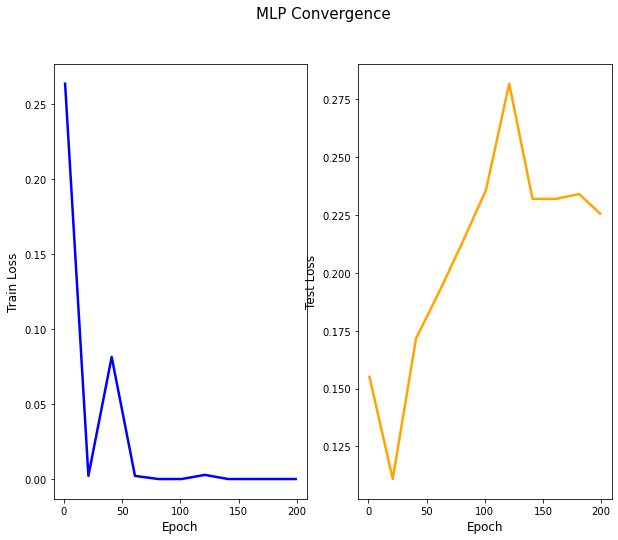

In [26]:
#parameters as in the paper

model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200 
size_minibatch = 128
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # weight_decay is an L2 regularisation to avoid overfitting

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

# running the MLP
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)

Epoch [1/200], Train Loss: 0.2174, Test Loss: 0.2792, Accuracy: 0.9183
Epoch [21/200], Train Loss: 0.0141, Test Loss: 0.0711, Accuracy: 0.9788
Epoch [41/200], Train Loss: 0.0011, Test Loss: 0.0705, Accuracy: 0.9822
Epoch [61/200], Train Loss: 0.0004, Test Loss: 0.0691, Accuracy: 0.9825
Epoch [81/200], Train Loss: 0.0003, Test Loss: 0.0689, Accuracy: 0.9825
Epoch [101/200], Train Loss: 0.0003, Test Loss: 0.0693, Accuracy: 0.9824
Epoch [121/200], Train Loss: 0.0212, Test Loss: 0.0785, Accuracy: 0.9792
Epoch [141/200], Train Loss: 0.0002, Test Loss: 0.0715, Accuracy: 0.9835
Epoch [161/200], Train Loss: 0.0001, Test Loss: 0.0699, Accuracy: 0.9839
Epoch [181/200], Train Loss: 0.0002, Test Loss: 0.0672, Accuracy: 0.9836
Final, Train Loss: 0.0002, Test Loss: 0.0666, Accuracy: 0.9832


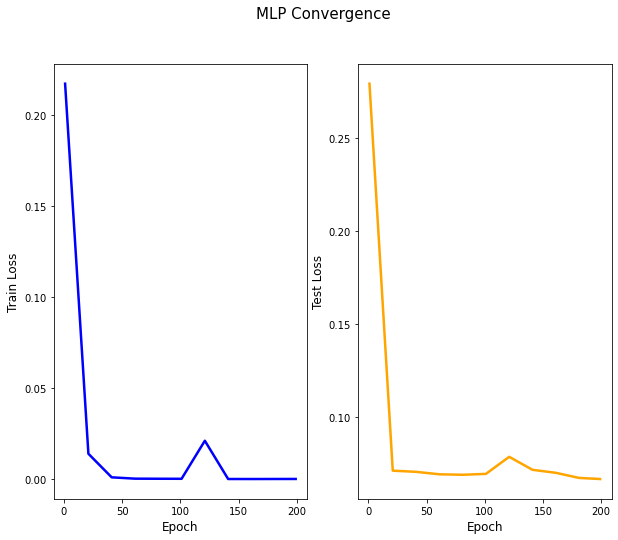

In [25]:
#changed batch size and added L2 regularization

model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200
size_minibatch = 1000
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), weight_decay = 1e-5, lr=learning_rate) # weight_decay is an L2 regularisation to avoid overfitting

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

# running the MLP
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)

Epoch [1/200], Train Loss: 0.1461, Test Loss: 0.1711, Accuracy: 0.9464
Epoch [21/200], Train Loss: 0.0074, Test Loss: 0.1499, Accuracy: 0.9733
Epoch [41/200], Train Loss: 0.0095, Test Loss: 0.1861, Accuracy: 0.9780
Epoch [61/200], Train Loss: 0.0147, Test Loss: 0.2458, Accuracy: 0.9769
Epoch [81/200], Train Loss: 0.0091, Test Loss: 0.3189, Accuracy: 0.9762
Epoch [101/200], Train Loss: 0.0126, Test Loss: 0.3490, Accuracy: 0.9782
Epoch [121/200], Train Loss: 0.0087, Test Loss: 0.4454, Accuracy: 0.9756
Epoch [141/200], Train Loss: 0.0116, Test Loss: 0.5535, Accuracy: 0.9728
Epoch [161/200], Train Loss: 0.0462, Test Loss: 0.5591, Accuracy: 0.9761
Epoch [181/200], Train Loss: 0.0294, Test Loss: 0.5872, Accuracy: 0.9775
Final, Train Loss: 0.0052, Test Loss: 0.5462, Accuracy: 0.9787


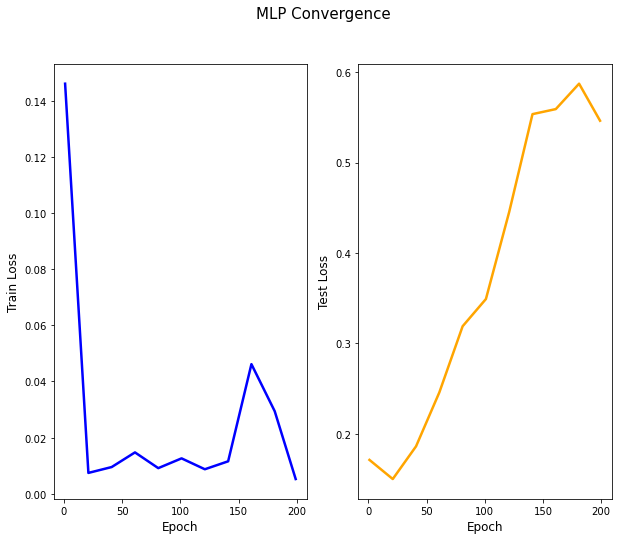

In [24]:
#icreased learning rate

model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200
size_minibatch = 1000
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), weight_decay = 1e-5, lr=learning_rate) # weight_decay is an L2 regularisation to avoid overfitting

# running the MLP
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)

Epoch [1/200], Train Loss: 0.8021, Test Loss: 0.8835, Accuracy: 0.8269
Epoch [21/200], Train Loss: 0.1093, Test Loss: 0.1457, Accuracy: 0.9578
Epoch [41/200], Train Loss: 0.0671, Test Loss: 0.0913, Accuracy: 0.9729
Epoch [61/200], Train Loss: 0.0429, Test Loss: 0.0715, Accuracy: 0.9774
Epoch [81/200], Train Loss: 0.0260, Test Loss: 0.0628, Accuracy: 0.9799
Epoch [101/200], Train Loss: 0.0144, Test Loss: 0.0599, Accuracy: 0.9809
Epoch [121/200], Train Loss: 0.0062, Test Loss: 0.0596, Accuracy: 0.9812
Epoch [141/200], Train Loss: 0.0030, Test Loss: 0.0605, Accuracy: 0.9812
Epoch [161/200], Train Loss: 0.0016, Test Loss: 0.0620, Accuracy: 0.9812
Epoch [181/200], Train Loss: 0.0010, Test Loss: 0.0636, Accuracy: 0.9812
Final, Train Loss: 0.0006, Test Loss: 0.0650, Accuracy: 0.9815


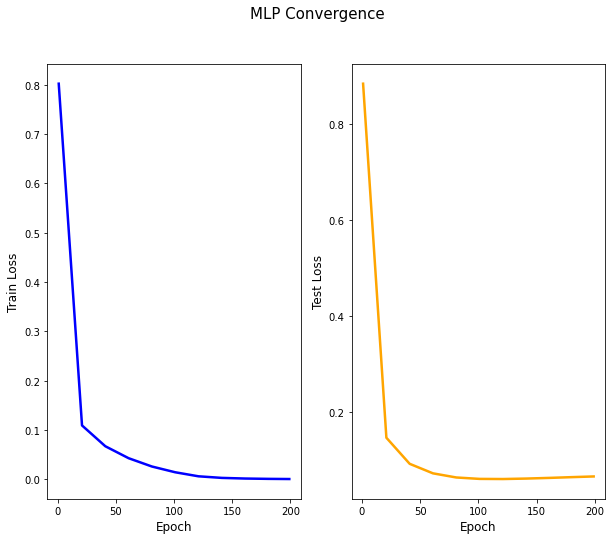

In [23]:
#decreased learning rate

model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200
size_minibatch = 1000
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), weight_decay = 1e-5, lr=learning_rate) # weight_decay is an L2 regularisation to avoid overfitting

# running the MLP
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)

Same with NosAdam

In [15]:
from NosAdam import NosAdam

Epoch [1/200], Train Loss: 0.2178, Test Loss: 0.2792, Accuracy: 0.9198
Epoch [21/200], Train Loss: 0.0157, Test Loss: 0.0783, Accuracy: 0.9770
Epoch [41/200], Train Loss: 0.0014, Test Loss: 0.0752, Accuracy: 0.9808
Epoch [61/200], Train Loss: 0.0005, Test Loss: 0.0768, Accuracy: 0.9815
Epoch [81/200], Train Loss: 0.0003, Test Loss: 0.0802, Accuracy: 0.9825
Epoch [101/200], Train Loss: 0.0002, Test Loss: 0.0830, Accuracy: 0.9824
Epoch [121/200], Train Loss: 0.0001, Test Loss: 0.0851, Accuracy: 0.9826
Epoch [141/200], Train Loss: 0.0001, Test Loss: 0.0870, Accuracy: 0.9826
Epoch [161/200], Train Loss: 0.0001, Test Loss: 0.0887, Accuracy: 0.9826
Epoch [181/200], Train Loss: 0.0001, Test Loss: 0.0902, Accuracy: 0.9825
Final, Train Loss: 0.0001, Test Loss: 0.0914, Accuracy: 0.9825


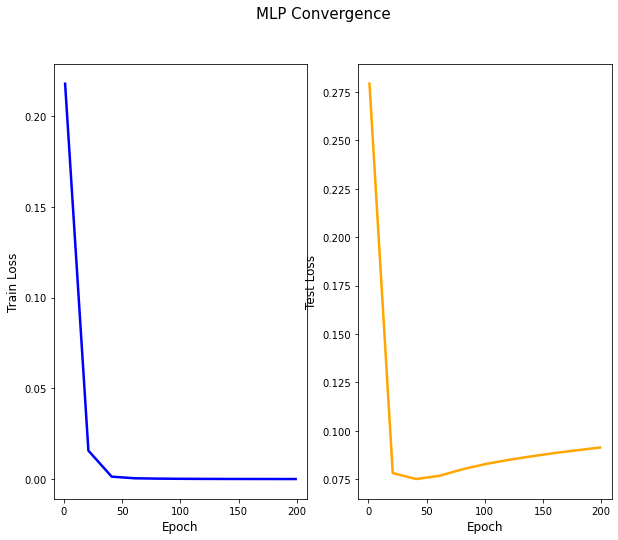

In [27]:
model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200
size_minibatch = 1000
learning_rate = 0.001
optimizer = NosAdam(model.parameters())

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

# running the MLP
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)

Epoch [1/200], Train Loss: 0.2227, Test Loss: 0.2823, Accuracy: 0.9171
Epoch [21/200], Train Loss: 0.0160, Test Loss: 0.0690, Accuracy: 0.9782
Epoch [41/200], Train Loss: 0.0016, Test Loss: 0.0729, Accuracy: 0.9799
Epoch [61/200], Train Loss: 0.0005, Test Loss: 0.0756, Accuracy: 0.9817
Epoch [81/200], Train Loss: 0.0003, Test Loss: 0.0786, Accuracy: 0.9818
Epoch [101/200], Train Loss: 0.0002, Test Loss: 0.0814, Accuracy: 0.9818
Epoch [121/200], Train Loss: 0.0001, Test Loss: 0.0838, Accuracy: 0.9818
Epoch [141/200], Train Loss: 0.0001, Test Loss: 0.0860, Accuracy: 0.9818
Epoch [161/200], Train Loss: 0.0001, Test Loss: 0.0878, Accuracy: 0.9819
Epoch [181/200], Train Loss: 0.0001, Test Loss: 0.0895, Accuracy: 0.9820
Final, Train Loss: 0.0001, Test Loss: 0.0909, Accuracy: 0.9819


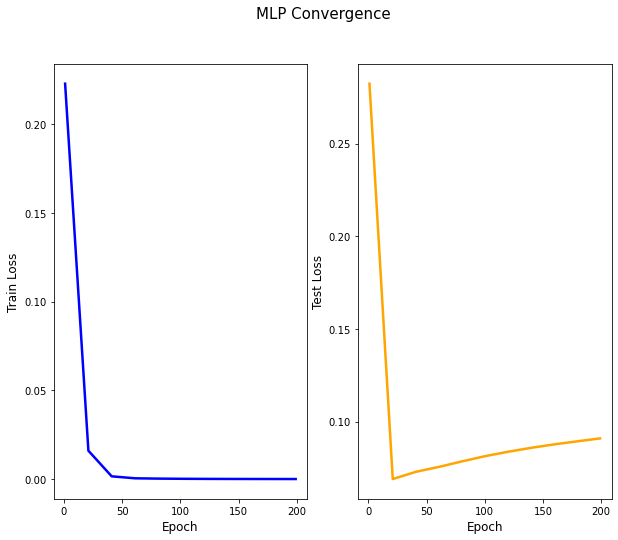

In [28]:
#increased learning rate

model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200
size_minibatch = 1000
learning_rate = 0.01
optimizer = NosAdam(model.parameters())

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

# running the MLP
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)

Epoch [1/200], Train Loss: 0.2143, Test Loss: 0.2751, Accuracy: 0.9218
Epoch [21/200], Train Loss: 0.0155, Test Loss: 0.0694, Accuracy: 0.9788
Epoch [41/200], Train Loss: 0.0011, Test Loss: 0.0693, Accuracy: 0.9804
Epoch [61/200], Train Loss: 0.0004, Test Loss: 0.0709, Accuracy: 0.9814
Epoch [81/200], Train Loss: 0.0003, Test Loss: 0.0741, Accuracy: 0.9815
Epoch [101/200], Train Loss: 0.0002, Test Loss: 0.0765, Accuracy: 0.9818
Epoch [121/200], Train Loss: 0.0001, Test Loss: 0.0784, Accuracy: 0.9815
Epoch [141/200], Train Loss: 0.0001, Test Loss: 0.0800, Accuracy: 0.9818
Epoch [161/200], Train Loss: 0.0001, Test Loss: 0.0816, Accuracy: 0.9815
Epoch [181/200], Train Loss: 0.0001, Test Loss: 0.0829, Accuracy: 0.9818
Final, Train Loss: 0.0001, Test Loss: 0.0841, Accuracy: 0.9818


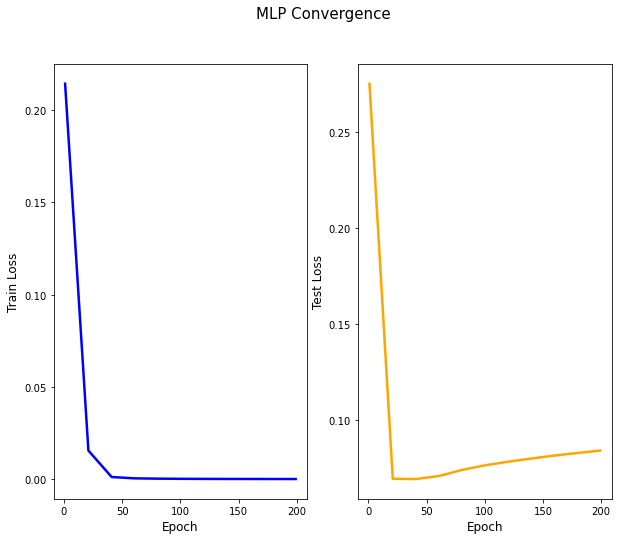

In [29]:
#decreased learning rate

model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200
size_minibatch = 1000
learning_rate = 0.0001
optimizer = NosAdam(model.parameters())

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

# running the MLP
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)